# BERTMultlingual training

Here we'll be training a BERTMultilingual model

Making the necessary imports

In [13]:
import multiprocessing
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from transformers import BertForSequenceClassification, BertTokenizer, get_scheduler

## Preparing the data

Reading the data and renaming the `y` column.


In [3]:
data = pd.read_csv("/content/financial_phrase_bank_pt_br.csv")
data = data.rename(columns={"y": "labels"})

Droping the `text` column, here we have an english column, and we're interested in finetuning the model using the portugues column.

In [4]:
data = data.drop(columns=["text"])

Transforming the `labels` columns so it represents our data in a way that the model will understand to predict.

In [5]:
def transform(x: str):
    if x == "neutral":
        return 2
    elif x == "negative":
        return 1
    else:
        return 0


data["labels"] = data["labels"].apply(transform)

Droping all rows where we don't have any text.

In [6]:
data = data.dropna(subset=["text_pt"])

Setting lists for the labels and the text.

In [7]:
text = data["text_pt"].tolist()
labels = data["labels"].tolist()

Importing our base model and the tokenizer.

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", num_labels=3
)

"Tokenizing" our texts.

In [10]:
encodings = tokenizer(text, truncation=True, padding=True)

Making the separation between train, test and validation for using during training.

We're using `scikit-learn train_test_split` so we can have the following ratio:

70% - training

15% - validation

15% - tests

In [11]:
input_ids = encodings["input_ids"]
attention_masks = encodings["attention_mask"]
token_type_ids = encodings["token_type_ids"]

# Split the encoded data and labels into train and temporary sets
train_inputs, tmp_inputs, train_labels, tmp_labels = train_test_split(
    input_ids, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels
)
train_masks, tmp_masks, _, _ = train_test_split(
    attention_masks,
    labels,
    test_size=0.3,
    random_state=42,
    shuffle=True,
    stratify=labels,
)
train_token_type_ids, tmp_token_type_ids, _, _ = train_test_split(
    token_type_ids,
    labels,
    test_size=0.3,
    random_state=42,
    shuffle=True,
    stratify=labels,
)

# Split the temporary set into validation and test sets
val_inputs, test_inputs, val_labels, test_labels = train_test_split(
    tmp_inputs,
    tmp_labels,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=tmp_labels,
)
val_masks, test_masks, _, _ = train_test_split(
    tmp_masks,
    tmp_labels,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=tmp_labels,
)
val_token_type_ids, test_token_type_ids, _, _ = train_test_split(
    tmp_token_type_ids,
    tmp_labels,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=tmp_labels,
)

Setting our "datasets" so we can pass it to the model.

In [30]:
train_dataset = [
    [train_inputs[x], train_masks[x], train_token_type_ids[x], train_labels[x]]
    for x in range(len(train_inputs))
]

val_dataset = [
    [val_inputs[x], val_masks[x], val_token_type_ids[x], val_labels[x]]
    for x in range(len(val_inputs))
]

test_dataset = [
    [test_inputs[x], test_masks[x], test_token_type_ids[x], test_labels[x]]
    for x in range(len(test_inputs))
]

## Training

Here we stabilish the main function for finetuning the model

In [33]:
def finetune_model():
    device = (
        torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    )

    model.to(device)

    learning_rate = 2e-6
    num_epochs = 100
    adam_epsilon = 1e-8

    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon)
    total_steps = len(train_dataset) * num_epochs

    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps,
    )

    def epoch_time(start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

    train_losses = []
    val_losses = []
    best_loss = None
    early_stop_min_delta = 0
    patience_time = 15
    last_best_result = 0
    criterion = CrossEntropyLoss()

    for n in range(num_epochs):
        train_loss = 0
        val_loss = 0
        start_time = time.time()

        lloss = []
        model.train()
        for step in range(len(train_dataset)):
            batch = train_dataset[step]
            input_ids = torch.tensor([batch[0]]).to(device)
            attention_mask = torch.tensor([batch[1]]).to(device)
            token_type_ids = torch.tensor([batch[2]]).to(device)
            labels = torch.tensor([batch[3]]).to(device)

            output = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
            )
            train_loss = criterion(output.logits, labels)
            train_loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            lloss.append(train_loss.item())

        avg_train_loss = np.mean(lloss)
        train_losses.append(avg_train_loss)

        lloss = []
        model.eval()

        with torch.no_grad():
            for step in range(len(val_dataset)):
                batch = val_dataset[step]
                input_ids = torch.tensor([batch[0]]).to(device)
                attention_mask = torch.tensor([batch[1]]).to(device)
                token_type_ids = torch.tensor([batch[2]]).to(device)
                labels = torch.tensor([batch[3]]).to(device)

                output = model(
                    input_ids=input_ids,
                    token_type_ids=token_type_ids,
                    attention_mask=attention_mask,
                )
                val_loss = criterion(output.logits, torch.tensor([batch[3]]).to(device))
                lloss.append(val_loss.item())

        avg_val_loss = np.mean(lloss)
        val_losses.append(avg_val_loss)

        print(f"\nTrain loss after iteration {n}: {avg_train_loss}")
        print(f"Validation loss after iteration {n}: {avg_val_loss}")
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Time: {epoch_mins}m {epoch_secs}s")

        if best_loss == None:
            best_loss = avg_val_loss
            last_best_result = 0
            print("Best model found! saving...")
            actual_state = {
                "AdawW": optimizer.state_dict(),
                "model": model.state_dict(),
                "epoch": num_epochs,
                "train_loss": train_losses,
                "val_loss": val_losses,
            }
            torch.save(actual_state, "best_model.pth")
        elif best_loss - avg_val_loss < early_stop_min_delta:
            best_loss = avg_val_loss
            last_best_result = 0
            print("Best model found! saving...")
            actual_state = {
                "AdawW": optimizer.state_dict(),
                "model": model.state_dict(),
                "epoch": num_epochs,
                "train_loss": train_losses,
                "val_loss": val_losses,
            }
            torch.save(actual_state, "best_model.pth")
        last_best_result += 1
        print(
            "epoch %d loss_train %4.3f loss_eval %4.3f last_best %d"
            % (n, train_losses[-1], val_losses[-1], last_best_result)
        )
        if last_best_result > patience_time:
            break

Calling the finetune function

In [ ]:
finetune_model()

## Evaluating the model

First we set our device again for using torch.

In [36]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Activate the model evaluation mode and make prediction in our test dataset.

In [40]:
model.eval()
lres = []
ytrue = []
with torch.no_grad():
    for step in range(len(test_dataset)):
        batch = test_dataset[step]
        input_ids = torch.tensor([batch[0]]).to(device)
        attention_mask = torch.tensor([batch[1]]).to(device)
        token_type_ids = torch.tensor([batch[2]]).to(device)

        output = model(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
        )
        res = output.logits.cpu()
        ytrue.append(batch[3])
        lres += res

Setting our predictions list for comparison.

In [41]:
ypred = [x.argmax(dim=0).cpu().tolist() for x in lres]

Printing our model metrics with a confusion matrix for better visualization.

                       model Metrics

              precision    recall  f1-score   support

           0       0.80      0.71      0.75       204
           1       0.78      0.71      0.75        91
           2       0.84      0.90      0.87       432

    accuracy                           0.82       727
   macro avg       0.81      0.77      0.79       727
weighted avg       0.82      0.82      0.82       727

Accuracy score  =  0.8239339752407153
Precision score =  0.8221449418565345
Recall score    =  0.8239339752407153



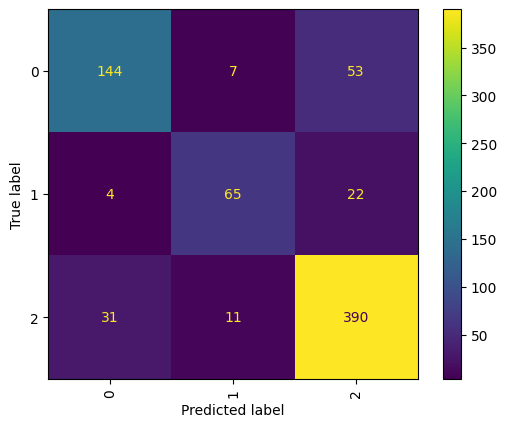

In [42]:
print("                       model Metrics")
print()
print(metrics.classification_report(ytrue, ypred))
print("Accuracy score  = ", metrics.accuracy_score(ytrue, ypred))
print("Precision score = ", metrics.precision_score(ytrue, ypred, average="weighted"))
print("Recall score    = ", metrics.recall_score(ytrue, ypred, average="weighted"))
print()
confusionmatrix = metrics.confusion_matrix(ytrue, ypred)
confusion = metrics.ConfusionMatrixDisplay(confusionmatrix)
confusion.plot(xticks_rotation="vertical")